In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=150,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3
import sys
sys.path.append("/home/qukun/xuhao/workspace/Utils")
import sc_plot
from sc_process import grouped_obs_mean
from sc_plot import plot_proportion

In [2]:
cx = sc.read_h5ad('../scripts/CX_20211030/s02_cx_annotated.h5ad')

In [3]:
class_mapper1 = {
    'Serous_acini_ANKRD36C':'Serous_acini',
    'Serous_acini_ELF3':'Serous_acini',
    'Serous_acini_SCGB3A1':'Serous_acini',
    'Serous_acini_TAGLN':'Serous_acini',
    'Serous_acini_LRRC26':'Serous_acini',
    'Serous_acini_MUC7':'Serous_acini',
    'Serous_acini_CLDN10':'Serous_acini',
    'Serous_acini_PRR4':'Serous_acini',
    'Mucous_acini_PI3':'Mucous_acini',
    'Mucous_acini_FCGBP':'Mucous_acini',
    'Mucous_acini_LTF':'Mucous_acini',
    'Ductal_ALDH1A3_CCL28':'Ductal',
    'Ductal_PI3':'Ductal',
    'Ductal_MIR205HG':'Ductal',
    'Ductal':'Ductal',
    'Ionocytes':'Ionocytes',
    'Myoepithelial':'Myoepithelial',
    'Fibroblast_DNAJB1':'Fibroblast',
    'Fibroblast_THBS4':'Fibroblast',
    'Fibroblast_APOE':'Fibroblast',
    'Fibroblast_PCOLCE2':'Fibroblast',
    'Fibroblast_CXCL9':'Fibroblast',
    'Myofibroblast':'SMC',
    'Endothelial_CA4':'Endothelial_CA4',
    'Endothelial_ACKR1_CCL14':'Endothelial_ACKR1_CCL14',
    'Endothelial_RGS5':'Endothelial_RGS5',
    # 'Endothelial_CA4':'Endothelial',
    # 'Endothelial_ACKR1_CCL14':'Endothelial',
    # 'Endothelial_RGS5':'Endothelial',
    'Pericytes':'Pericytes',
    'Melanocytes':'Melanocytes',
    'CD4_T_ICOS':'T',
    'CD4_T_CCL5':'T',
    'CD8_T_CREM_HSPA1A':'T',
    'CD8_T_GZMA':'T',
    'CD8_T_GZMB':'T',
    'B':'B',
    'Plasma_IGKV2D-28':'Plasma',
    'Plasma_IGHG2':'Plasma',
    'Plasma_HSPB1':'Plasma',
    'Plasma_IGHA2':'Plasma',
    'Mac/mo_IL1B':'Myeloid',
    'Mac/mo_CCL18':'Myeloid',
    'Mast':'Myeloid',
    'Unknown':'Unknown'}

In [4]:
cx.obs['cell_class1'] = [class_mapper1[c] for c in cx.obs['celltype_minor']]

In [5]:
cx = cx[cx.obs['cell_class1'] != 'Unknown']

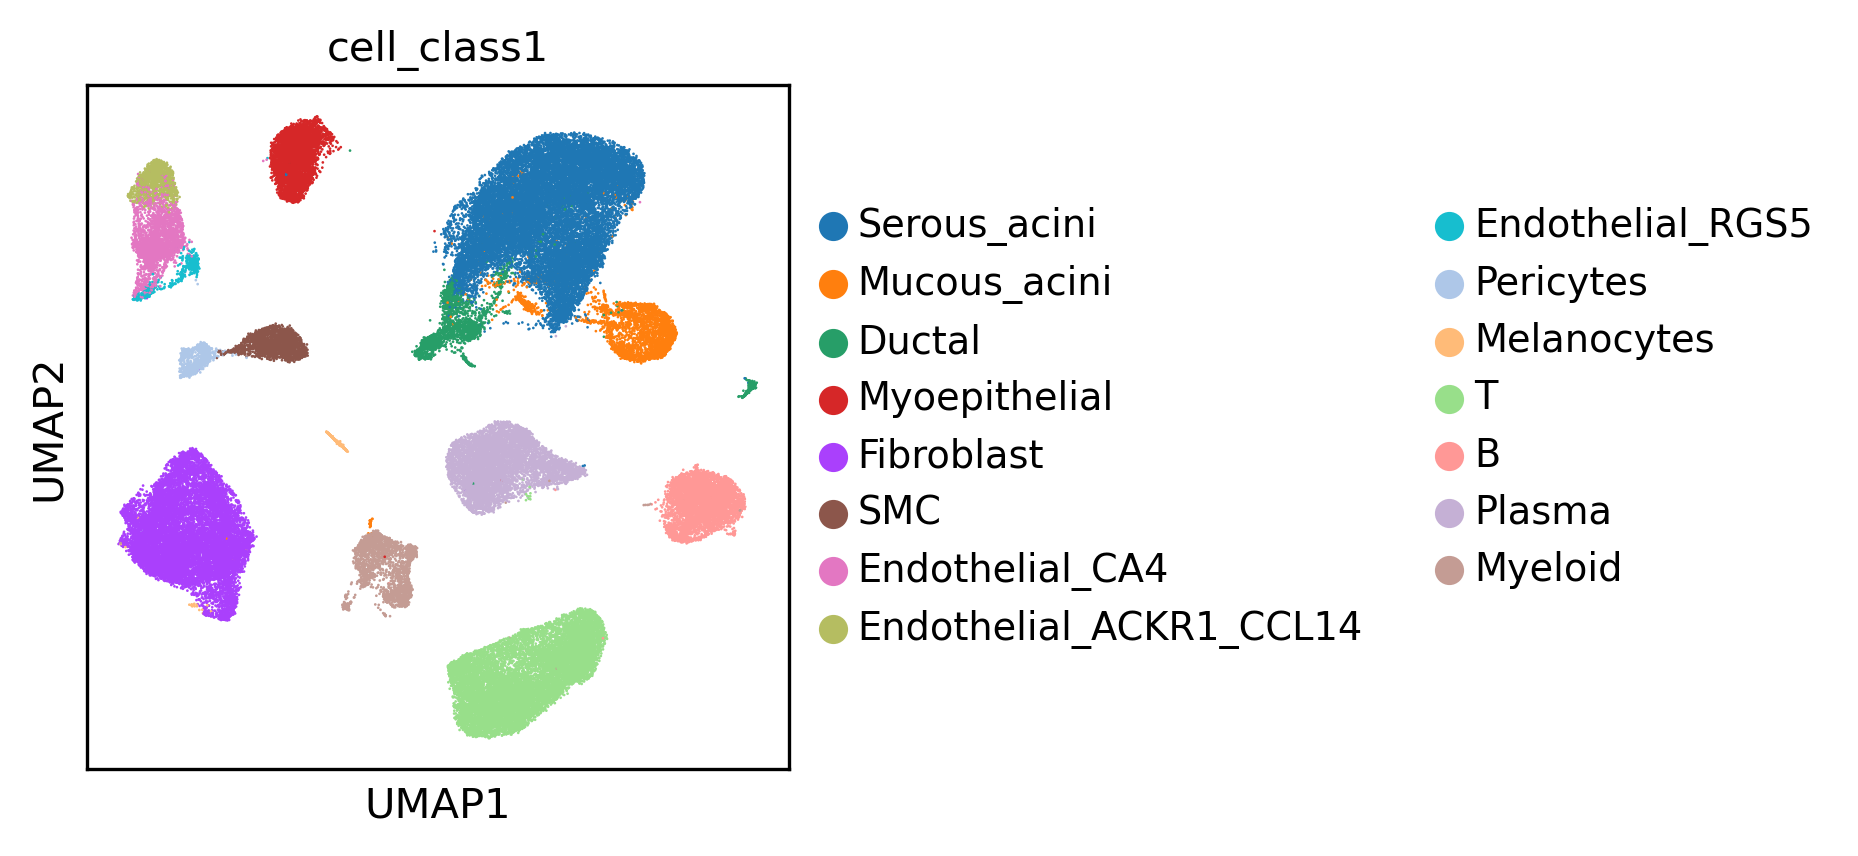

In [47]:
sc.pl.umap(cx_epi,color=['cell_class1'],frameon=True)

In [ ]:
sc.tl.rank_genes_groups(cx,groupby='cell_class1',use_raw=False,pts=True,methods='wilcoxon')

In [ ]:
celltype_order = ['Serous_acini','Mucous_acini','Ductal','Myoepithelial','Ionocytes','Fibroblast','SMC','Endothelial_CA4','Endothelial_ACKR1_CCL14','Endothelial_RGS5','Pericytes','Melanocytes','T','B','Plasma','Myeloid']

In [ ]:
top10_degs = []
for celltype in celltype_order:
    tmp_df = sc.get.rank_genes_groups_df(cx,group=celltype,log2fc_min=0.5,pval_cutoff=0.01)
    tmp_df = tmp_df[tmp_df['pct_nz_group'] > 0.2].sort_values(by='logfoldchanges',ascending=False)
    tmp_df = tmp_df.head(10)
    top10_degs.extend(tmp_df['names'])

In [61]:
cx.obs_names_make_unique()

In [88]:
expr_df = pd.concat([cx.to_df().loc[:,top10_degs], cx.obs[['cell_class1']]],axis=1)

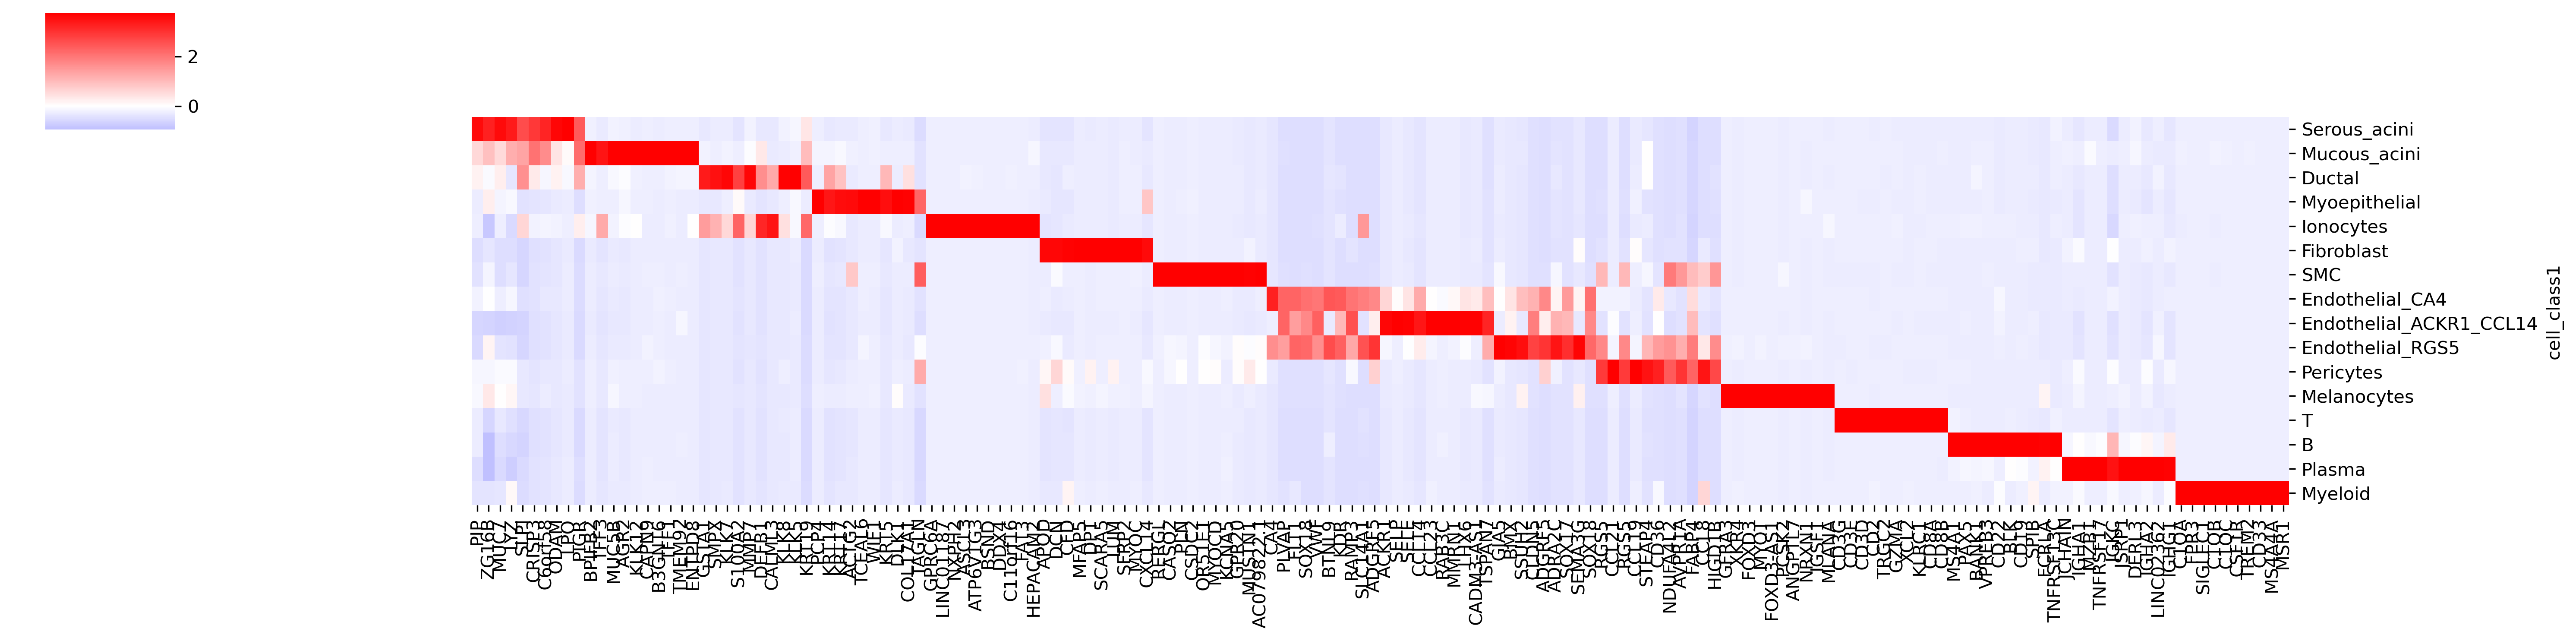

In [91]:
sns.clustermap(expr_df.groupby('cell_class1').mean(0).loc[celltype_order,:],row_cluster=False,col_cluster=False,xticklabels=True,yticklabels=True,figsize=(20,5),cmap='bwr',z_score=1,center=0)
plt.savefig('cx_results/clustermap_cx_cell_class1_top10_degs.pdf',bbox_inches='tight')

In [45]:
sc.tl.dendrogram(cx,groupby='cell_class1')

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_cell_class1']`


In [ ]:
cx_cli_state_df = []
for c in cx.obs.cell_class1.unique():
    cx_ctmp = cx[cx.obs.cell_class1==c].copy()
    if len(np.unique(cx_ctmp.obs.cli_state)) > 1:
        sc.tl.rank_genes_groups(cx_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
        cx_ctmp_df = sc.get.rank_genes_groups_df(cx_ctmp,group='SjS',key=f'{c}_cli')
        cx_ctmp_df['cell_class1'] = c
        cx_cli_state_df.append(cx_ctmp_df)
cx_cli_state_df = pd.concat(cx_cli_state_df,axis=0)

In [29]:
cx_cli_state_df_filtered = cx_cli_state_df[(cx_cli_state_df.pvals_adj < 0.01) & (cx_cli_state_df.pct_nz_group > 0.1)]

In [39]:
for i in cx_cli_state_df_filtered.index:
    cell_class_fc_df.loc[cx_cli_state_df_filtered.loc[i,'cell_class1'],cx_cli_state_df_filtered.loc[i,'names']] = cx_cli_state_df_filtered.loc[i,'logfoldchanges']

In [13]:
cx_cell_class1_df = []
for c in cx.obs.cell_class1.unique():
    cx_ctmp_df = sc.get.rank_genes_groups_df(cx,group=c)
    cx_ctmp_df['celltype'] = c
    cx_cell_class1_df.append(cx_ctmp_df)
cx_cell_class1_df = pd.concat(cx_cell_class1_df,axis=0)

cx_cell_class1_df_filter = cx_cell_class1_df[(np.abs(cx_cell_class1_df.logfoldchanges) > 0.5)&(cx_cell_class1_df.pvals_adj < 0.01)&(cx_cell_class1_df.pct_nz_group >0.1)]
cx_cell_class1_df_filter.to_csv('cx_results/cx_cell_class1_deg_df_filter.csv')

In [7]:
celltype_major_major_map = pd.DataFrame(np.array(['Epithelial','Epithelial','Epithelial','Plasma','Myeloid','Endothelial','T','Ionocytes','T','SMC','Pericytes','B','Epithelial','Fibroblast','Melanocytes','Myeloid']),index=np.array(cx.obs.celltype_major.unique()))
cx.obs['celltype_major_major'] = pd.Categorical(celltype_major_major_map.loc[cx.obs.celltype_major,:][0].values)
cx.obs.celltype_major_major = pd.Categorical(cx.obs.celltype_major_major, categories=['Epithelial','Ionocytes','Fibroblast','SMC','Endothelial','Pericytes','Melanocytes','T','B','Plasma','Myeloid'])

In [8]:
cx.obs.celltype_major_major = np.array(cx.obs.celltype_major_major)

In [9]:
cx.obs.loc[cx.obs.celltype_minor == 'Endothelial_ACKR1_CCL14','celltype_major_major'] = 'Endothelial_ACKR1'
cx.obs.loc[cx.obs.celltype_minor == 'Endothelial_RGS5','celltype_major_major'] = 'Endothelial_RGS5'
cx.obs.loc[cx.obs.celltype_minor == 'Endothelial_CA4','celltype_major_major'] = 'Endothelial_CA4'

cx.obs.loc[cx.obs.celltype_major == 'Serous_acini','celltype_major_major'] = 'Serous_acini'
cx.obs.loc[cx.obs.celltype_major == 'Mucous_acini','celltype_major_major'] = 'Mucous_acini'
cx.obs.loc[cx.obs.celltype_major == 'Ductal','celltype_major_major'] = 'Ductal'
cx.obs.loc[cx.obs.celltype_major == 'Myoepithelial','celltype_major_major'] = 'Myoepithelial'

In [10]:
cx = cx[~pd.isna(cx.obs['celltype_major_major'])]

In [12]:
celltype_sample_cell_number_value_counts = cx.obs[['sample','celltype_major_major']].value_counts()

celltype_sample_cell_number_df = pd.DataFrame(index=np.unique(cx.obs['sample']),columns=np.unique(cx.obs['celltype_major_major'])).fillna(0)

for s,c in celltype_sample_cell_number_value_counts.index:
    celltype_sample_cell_number_df.loc[s,c] = celltype_sample_cell_number_value_counts.loc[(s,c),]

# celltype_sample_cell_number_df.to_csv('cx_results/cx_sample_celltype_cell_number.csv')

In [13]:
cx.uns['celltype_major_major_colors'] = [matplotlib.colors.to_hex(c) for c in [sns.color_palette(n_colors=12)[0]]+[sns.color_palette(n_colors=12)[11]]+sns.color_palette(n_colors=12)[1:11]]

Trying to set attribute `.uns` of view, copying.


In [14]:
celltype_major_major_map.index = [c.split('_')[0] for c in celltype_major_major_map.index]

In [4]:
cx_cli_state_df = []
for c in cx.obs.celltype_minor.unique():
    cx_ctmp = cx[cx.obs.celltype_minor==c].copy()
    if len(np.unique(cx_ctmp.obs.cli_state)) > 1:
        sc.tl.rank_genes_groups(cx_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
        cx_ctmp_df = sc.get.rank_genes_groups_df(cx_ctmp,group='SjS',key=f'{c}_cli')
        cx_ctmp_df['celltype_minor'] = c
        cx_cli_state_df.append(cx_ctmp_df)
cx_cli_state_df = pd.concat(cx_cli_state_df,axis=0)

# cx_cli_state_df = []
# for c in np.unique(cx.obs.celltype_major_major):
#     cx_ctmp = cx[cx.obs.celltype_major_major==c].copy()
#     sc.tl.rank_genes_groups(cx_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
#     cx_ctmp_df = sc.get.rank_genes_groups_df(cx_ctmp,group='SjS',key=f'{c}_cli')
#     cx_ctmp_df['celltype_major_major'] = c
#     cx_cli_state_df.append(cx_ctmp_df)
# cx_cli_state_df = pd.concat(cx_cli_state_df,axis=0)

ranking genes
    finished: added to `.uns['Serous_acini_MUC7_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)
ranking genes
    finished: added to `.uns['Serous_acini_CLDN10_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes
    finished: added to `.uns['Serous_acini_LRRC26_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.

In [5]:
cx_cli_state_logfc = pd.DataFrame(index=cx_cli_state_df.celltype_minor.unique(),columns=cx_cli_state_df.names.unique())
cx_cli_state_pval = pd.DataFrame(index=cx_cli_state_df.celltype_minor.unique(),columns=cx_cli_state_df.names.unique())
cx_cli_state_pts = pd.DataFrame(index=cx_cli_state_df.celltype_minor.unique(),columns=cx_cli_state_df.names.unique())
cx_cli_state_scores = pd.DataFrame(index=cx_cli_state_df.celltype_minor.unique(),columns=cx_cli_state_df.names.unique())
for c in cx_cli_state_df.celltype_minor.unique():
    cx_cli_state_df_tmp = cx_cli_state_df[cx_cli_state_df.celltype_minor == c]
    cx_cli_state_logfc.loc[c,cx_cli_state_df_tmp.names] = cx_cli_state_df_tmp.logfoldchanges.values
    cx_cli_state_pval.loc[c,cx_cli_state_df_tmp.names] = cx_cli_state_df_tmp.pvals_adj.values
    cx_cli_state_pts.loc[c,cx_cli_state_df_tmp.names] = cx_cli_state_df_tmp.pct_nz_group.values
    cx_cli_state_scores.loc[c,cx_cli_state_df_tmp.names] = cx_cli_state_df_tmp.scores.values
cx_cli_state_logfc = cx_cli_state_logfc.fillna(0)
cx_cli_state_pval = cx_cli_state_pval.fillna(0)
cx_cli_state_pts = cx_cli_state_pts.fillna(0)
cx_cli_state_scores = cx_cli_state_scores.fillna(0)

In [6]:
cx_cli_state_up_logfc = cx_cli_state_logfc.loc[:,(((cx_cli_state_pts.values > 0.1)&(cx_cli_state_logfc.values > 0.5)&(cx_cli_state_pval.values < 0.01)).sum(0) != 0)]
cx_cli_state_down_logfc = cx_cli_state_logfc.loc[:,(((cx_cli_state_pts.values > 0.1)&(cx_cli_state_logfc.values < -0.5)&(cx_cli_state_pval.values < 0.01)).sum(0) != 0)]

In [7]:
cx_cli_state_up_logfc = cx_cli_state_up_logfc*(cx_cli_state_pval.loc[:,cx_cli_state_up_logfc.columns].values < 0.01)
cx_cli_state_down_logfc = cx_cli_state_down_logfc*(cx_cli_state_pval.loc[:,cx_cli_state_down_logfc.columns].values < 0.01)

In [12]:
major_up_deg_counts = pd.DataFrame([((cx_cli_state_up_logfc[(celltype_major_major_map.loc[[c.split('_')[0] for c in cx_cli_state_up_logfc.index],0] == c).values]>0.5).sum(0)!=0).sum() for c in np.unique(celltype_major_major_map[0].values)],index=np.unique(celltype_major_major_map[0].values))
major_down_deg_counts = pd.DataFrame([((cx_cli_state_down_logfc[(celltype_major_major_map.loc[[c.split('_')[0] for c in cx_cli_state_down_logfc.index],0] == c).values]<-0.5).sum(0)!=0).sum() for c in np.unique(celltype_major_major_map[0].values)],index=np.unique(celltype_major_major_map[0].values))

In [14]:
major_up_deg_counts.to_csv('cx_celltype_major_major_up_deg_counts.csv')

In [21]:
order = (major_up_deg_counts+major_down_deg_counts).sort_values(by=0,ascending=False).index

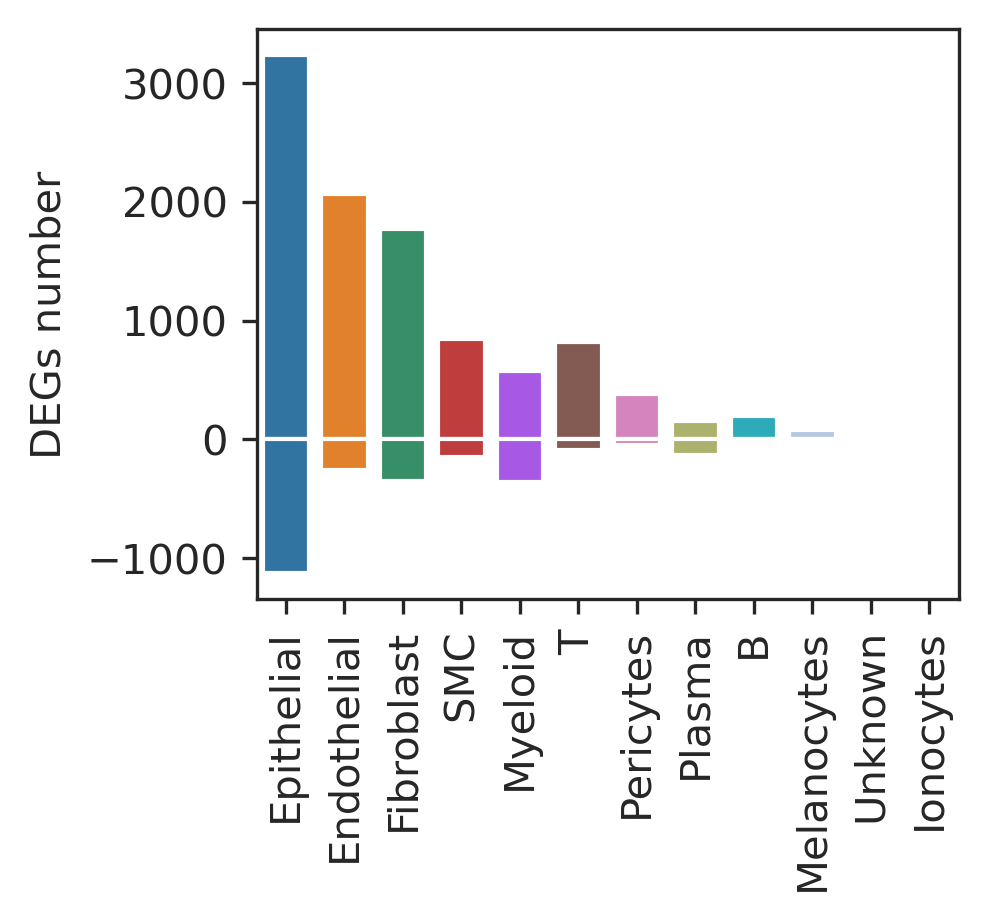

In [113]:
sns.set_style('ticks')
plt.subplots(figsize=(3,2.5))
sns.barplot(x=np.arange(len(major_up_deg_counts)),y=major_up_deg_counts.loc[order,0])
sns.barplot(x=np.arange(len(major_down_deg_counts)),y=-major_down_deg_counts.loc[order,0])
plt.xticks(np.arange(len(major_down_deg_counts)),order,rotation=90)
plt.ylabel('DEGs number')
# plt.savefig('figures/barplot_cx_cell_class_degs_number.pdf',bbox_inches='tight',dpi=300)
plt.show()

In [117]:
cell_type = cx.obs['celltype_major_major'].cat.categories
cell_tpye_df = {}
for ct in cell_type:
    cell_tpye_df[ct] = len(cx[cx.obs['celltype_major_major'] == ct])

In [127]:
cell_tpye_df

{'Epithelial': 27742,
 'Ionocytes': 336,
 'Fibroblast': 12522,
 'SMC': 1857,
 'Endothelial': 4291,
 'Pericytes': 934,
 'Melanocytes': 496,
 'T': 11664,
 'B': 4499,
 'Plasma': 5920,
 'Myeloid': 2310}

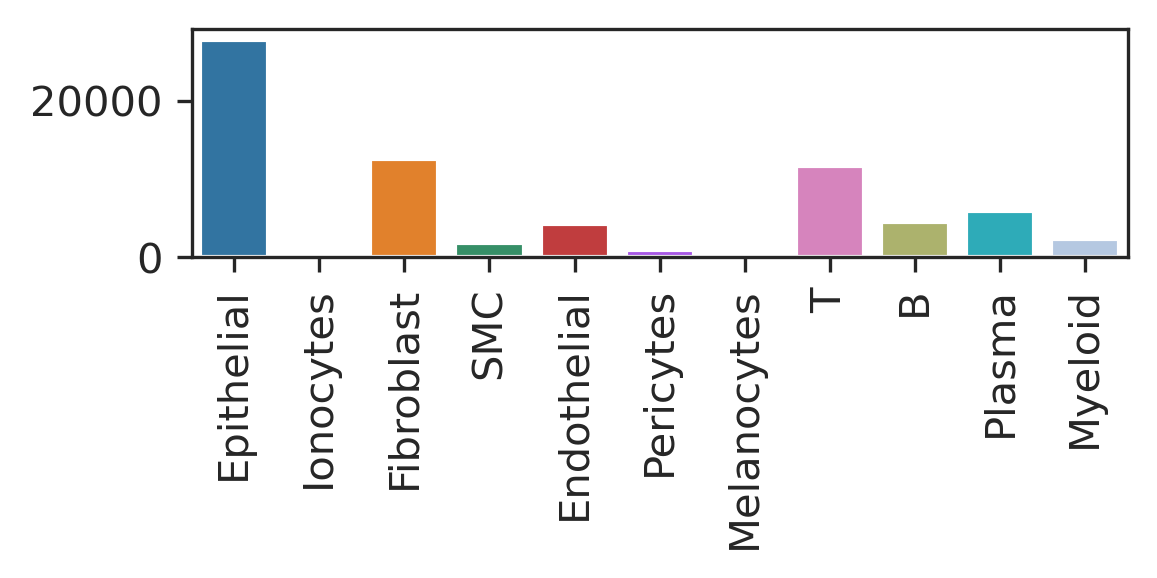

In [130]:
fig,ax = plt.subplots(figsize=(4,1))
sns.barplot(y=list(cell_tpye_df.values()),x=list(cell_tpye_df.keys()),palette=cx.uns['celltype_major_major_colors'])
plt.xticks(rotation=90)
plt.savefig('figures/barplot_cx_celltype_major_major_proportion.pdf',bbox_inches='tight')
plt.show()

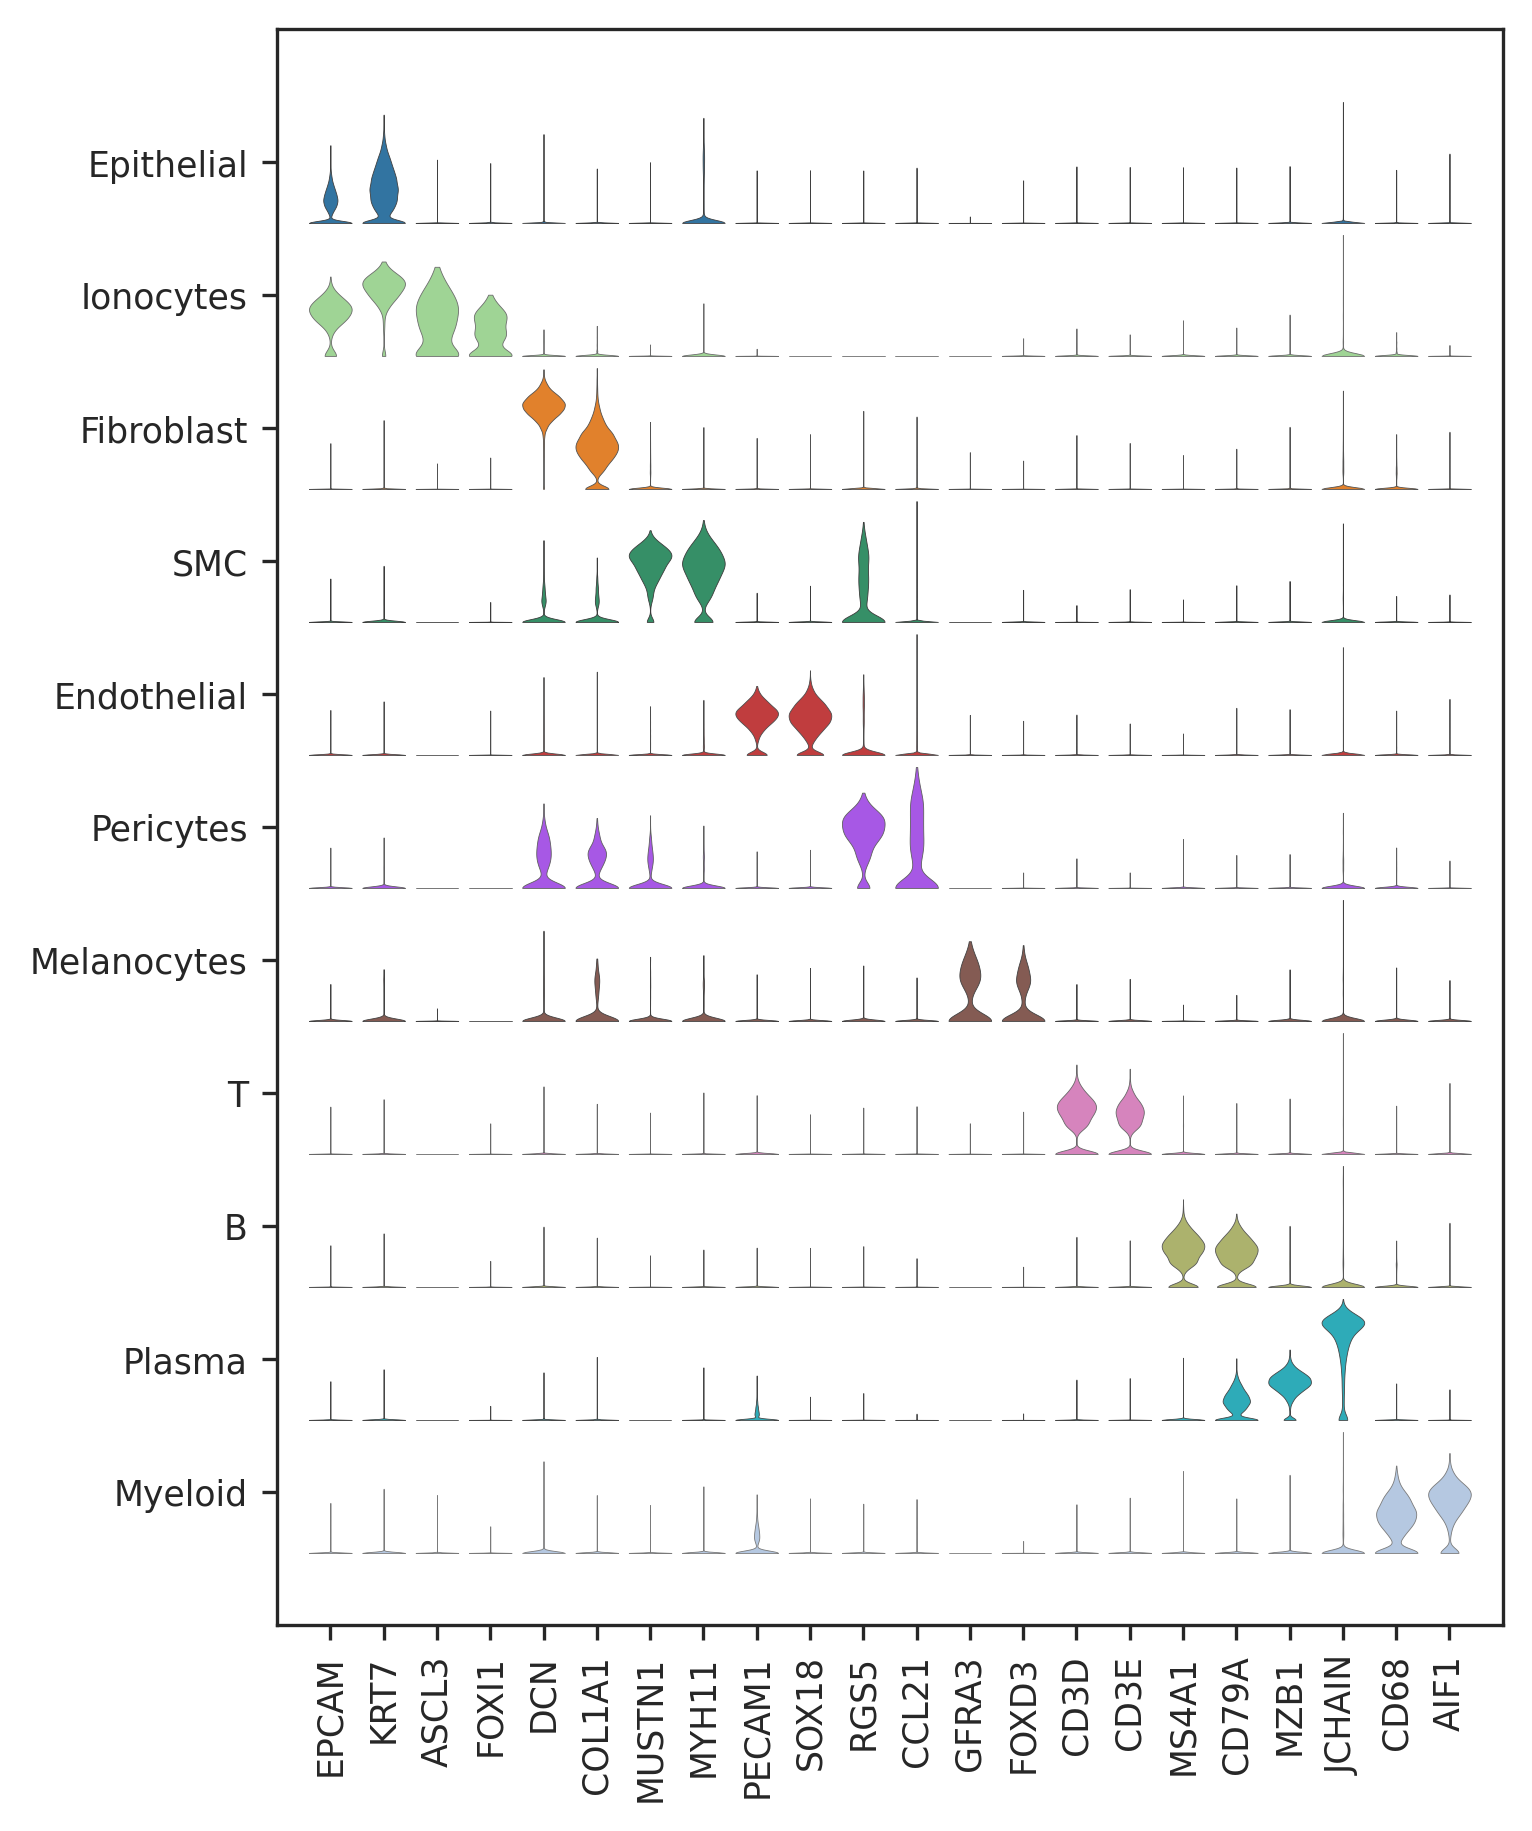

In [114]:
sc.pl.stacked_violin(cx,['EPCAM','KRT7','ASCL3','FOXI1', 'DCN', 'COL1A1', 'MUSTN1', 'MYH11', 'PECAM1', 'SOX18', 'RGS5', 'CCL21', 'GFRA3', 'FOXD3', 'CD3D', 'CD3E', 'MS4A1', 'CD79A', 'MZB1', 'JCHAIN', 'CD68', 'AIF1'],groupby='celltype_major_major',cmap='Reds',use_raw=False,vmax=4,edgecolor=None,row_palette=cx.uns['celltype_major_major_colors'],figsize=(7,7),save='cx_celltype_major_major_makers.pdf')

In [16]:
cx.obs[['umap_1','umap_2']] = cx.obsm['X_umap']

In [18]:
pd.concat([cx.obs[['umap_1','umap_2','cli_state','sample','cell_class1','celltype_major_major','nFeature_RNA','nCount_RNA','percent.mt']],cx.to_df().loc[:,['EPCAM','KRT7','ASCL3','FOXI1', 'DCN', 'COL1A1', 'MUSTN1', 'MYH11', 'PECAM1', 'SOX18', 'RGS5', 'CCL21', 'GFRA3', 'FOXD3', 'CD3D', 'CD3E', 'MS4A1', 'CD79A', 'MZB1', 'JCHAIN', 'CD68', 'AIF1']]],axis=1).to_csv('source_data/source_data_fig1b&d&sfig1abc.csv')

# Celltype proportion

In [23]:
def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):
    """
    Input
    =====
    adata : AnnData object
    cluster_key : key of `adata.obs` storing cluster info
    sample_key : key of `adata.obs` storing sample/replicate info
    drop_values : list/iterable of possible values of `sample_key` that you don't want
    
    Returns
    =======
    pd.DataFrame with samples as the index and clusters as the columns and 0-100 floats
    as values
    """
    
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props


def plot_cluster_proportions(cluster_props, 
                             cluster_palette=None,
                             xlabel_rotation=0): 
    fig, ax = plt.subplots(dpi=300)
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cluster")
    sns.despine(fig, ax)
    ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize())
    ax.set_ylabel("Proportion")
    fig.tight_layout()
    
    return fig

In [25]:
# class_p_df = get_cluster_proportions(cx,cluster_key='cell_class',sample_key='sample')
class_p_df = get_cluster_proportions(cx,cluster_key='celltype_major_major',sample_key='sample')

In [26]:
class_p_df_count = pd.DataFrame()
count = 0
for i in class_p_df.index:
    for c in class_p_df.columns:
        # class_p_df_count.loc[count,['cell_class','sample','proportion']] = [c,i,class_p_df.loc[i,c]]
        class_p_df_count.loc[count,['celltype_major_major','sample','proportion']] = [c,i,class_p_df.loc[i,c]]
        count += 1
class_p_df_count.loc[class_p_df_count['sample'].isin(['HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5']),'cli_state'] = 'HC'
class_p_df_count.loc[class_p_df_count['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11']),'cli_state'] = 'SjS'
class_p_df_count

,celltype_major_major,sample,proportion,cli_state
0,B,HCCX_1,0.180808,HC
1,Endothelial,HCCX_1,10.448147,HC
2,Epithelial,HCCX_1,40.333204,HC
3,Fibroblast,HCCX_1,27.676611,HC
4,Ionocytes,HCCX_1,0.077489,HC
...,...,...,...,...
187,Pericytes,XNCX_11,0.801564,SjS
188,Plasma,XNCX_11,24.809384,SjS
189,SMC,XNCX_11,5.513196,SjS
190,T,XNCX_11,9.051808,SjS


In [28]:
# class_p_df_count = pd.concat([class_p_df_count[class_p_df_count['cell_class'] == c] for c in order],axis=0)
class_p_df_count = pd.concat([class_p_df_count[class_p_df_count['celltype_major_major'] == c] for c in order],axis=0)

In [29]:
class_p_df_count

,celltype_major_major,sample,proportion,cli_state
2,Epithelial,HCCX_1,40.333204,HC
14,Epithelial,HCCX_2,89.403974,HC
26,Epithelial,HCCX_3,21.498584,HC
38,Epithelial,HCCX_4,27.038627,HC
50,Epithelial,HCCX_5,75.521144,HC
...,...,...,...,...
136,Ionocytes,XNCX_7,0.632737,SjS
148,Ionocytes,XNCX_8,0.042965,SjS
160,Ionocytes,XNCX_9,0.075429,SjS
172,Ionocytes,XNCX_10,0.000000,SjS


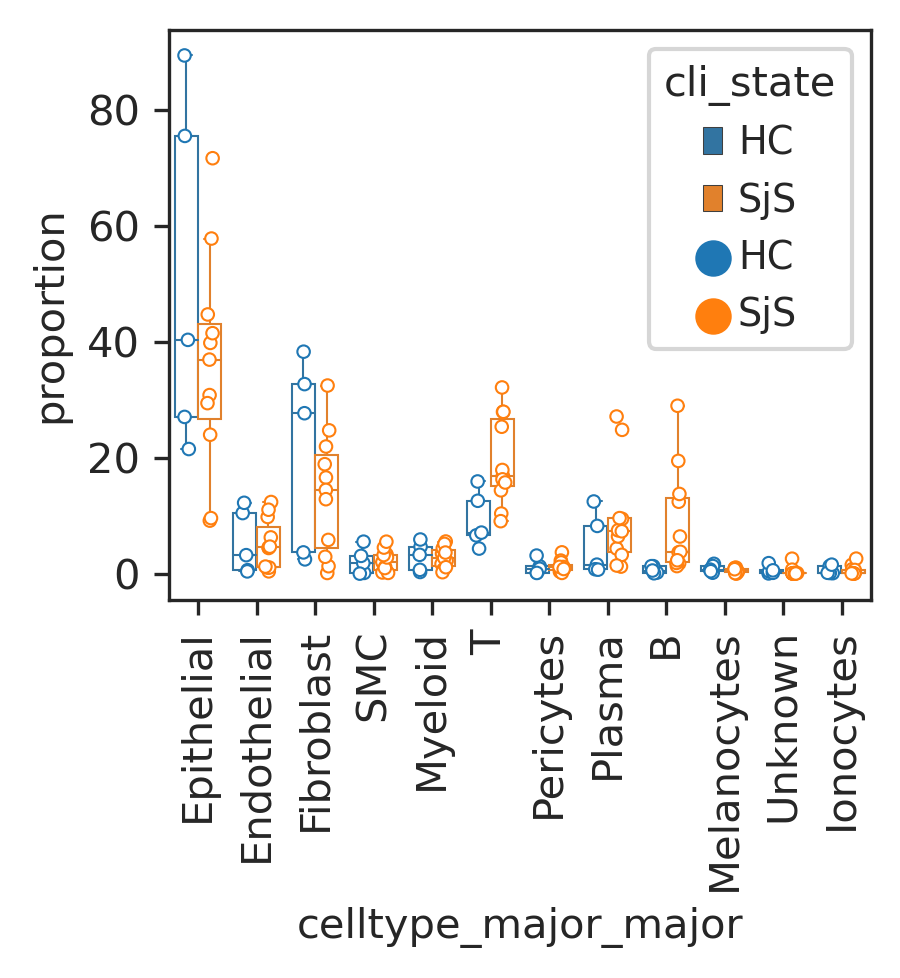

In [31]:
fig,ax=plt.subplots(figsize=(3,2.5))
sns.boxplot(data=class_p_df_count,y='proportion',x='celltype_major_major',hue='cli_state',ax=ax,fliersize=0,linewidth=0.5)
sns.stripplot(data=class_p_df_count,y='proportion',x='celltype_major_major',hue='cli_state',ax=ax,dodge=True,size=3,linewidth=0.5)
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
# plt.savefig('figures/boxplot_cx_cell_class_proportion.pdf',bbox_inches='tight')
plt.savefig('figures/boxplot_cx_celltype_major_major_proportion.pdf',bbox_inches='tight')
plt.show()

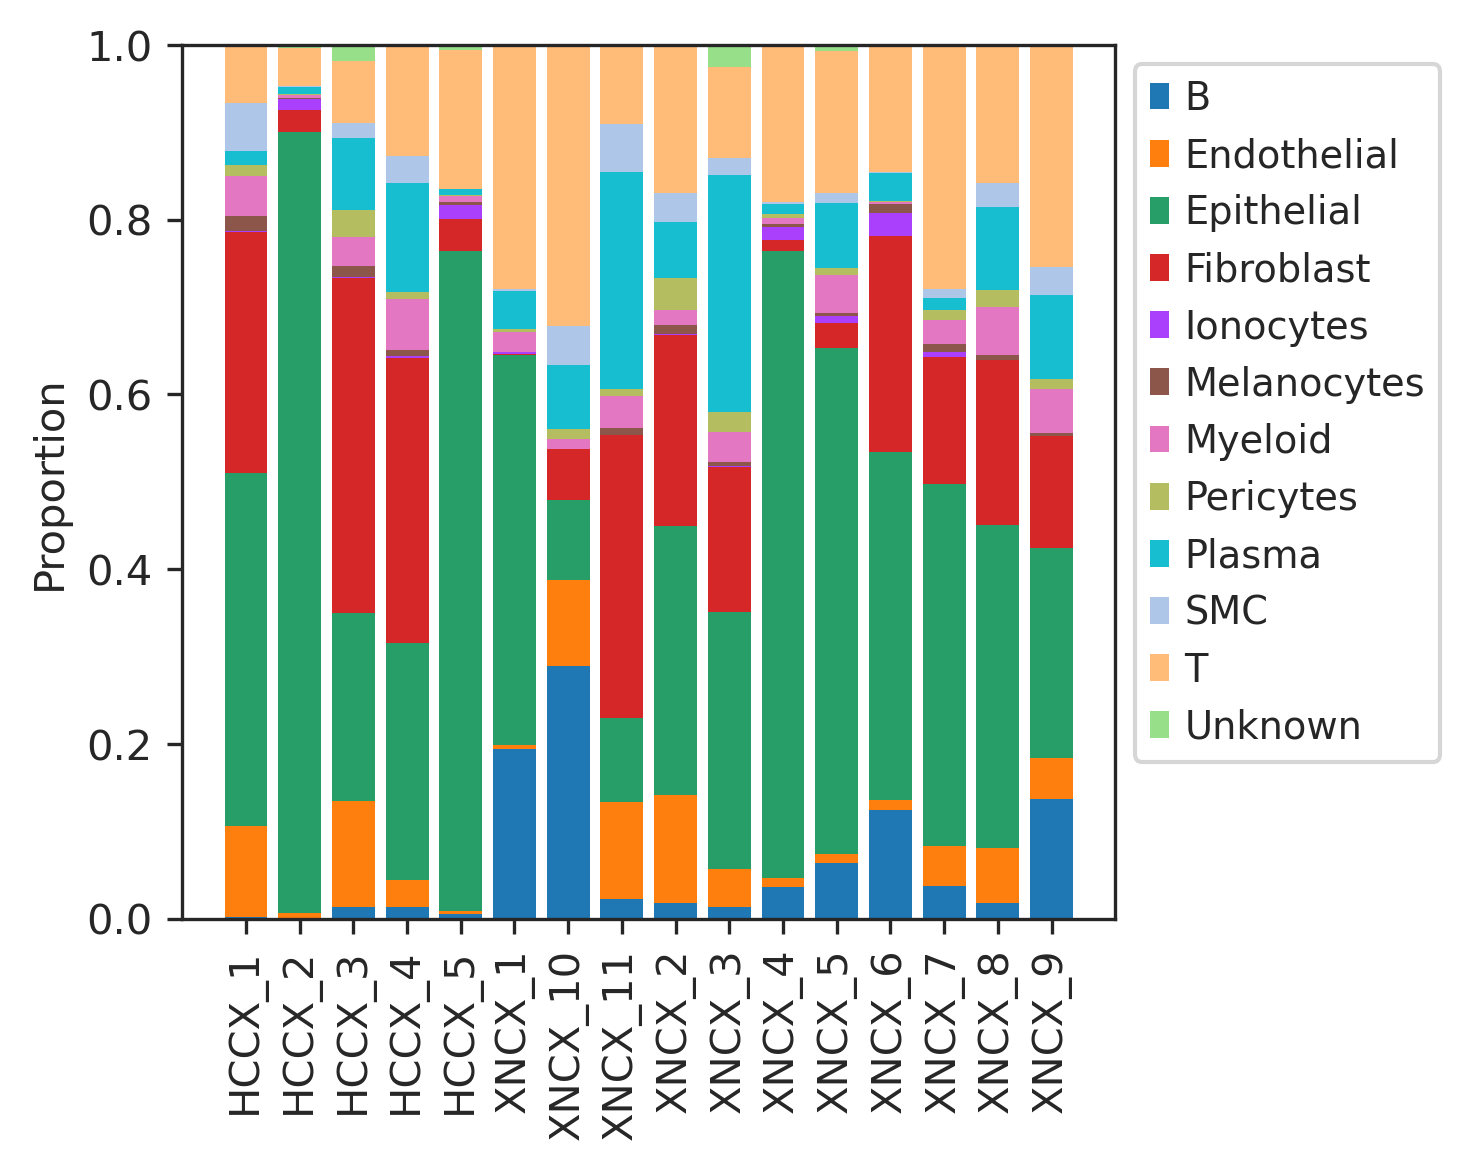

In [37]:
sns.set_style('ticks')
# p_df = sc_plot.plot_proportion(cx.obs,obs_x='sample',obs_y='celltype_major',obs_y_order=cx.obs.celltype_major.cat.categories,figsize=(5,4),colors=cx.uns['celltype_major_colors'],save='figures/barplot_cx_sample_celltype_major.pdf')
p_df = sc_plot.plot_proportion(cx.obs,obs_x='sample',obs_y='celltype_major_major',obs_y_order=cx.obs.celltype_major_major.cat.categories,figsize=(5,4),save='figures/barplot_cx_sample_celltype_major_major.pdf')

In [32]:
from scipy.stats import ttest_ind

In [38]:
for i,c in enumerate(p_df.index):
    print(c)
    print(ttest_ind(p_df.iloc[i,:5],p_df.iloc[i,5:]))

B
Ttest_indResult(statistic=-1.952785342952589, pvalue=0.0711332601341927)
Endothelial
Ttest_indResult(statistic=0.08342511407639602, pvalue=0.9346946488614735)
Epithelial
Ttest_indResult(statistic=1.216770310053158, pvalue=0.2438070263252099)
Fibroblast
Ttest_indResult(statistic=1.0518383404909435, pvalue=0.3106910228140138)
Ionocytes
Ttest_indResult(statistic=0.19714474086583927, pvalue=0.8465477590381675)
Melanocytes
Ttest_indResult(statistic=1.3483980359709709, pvalue=0.19894137642617968)
Myeloid
Ttest_indResult(statistic=0.12873368973989072, pvalue=0.8993994580460063)
Pericytes
Ttest_indResult(statistic=-0.25710330423299926, pvalue=0.8008391714436812)
Plasma
Ttest_indResult(statistic=-1.0705151407935927, pvalue=0.30249686443288315)
SMC
Ttest_indResult(statistic=-0.07893911889411688, pvalue=0.9381982672347196)
T
Ttest_indResult(statistic=-2.700428255029033, pvalue=0.017242184104490754)
Unknown
Ttest_indResult(statistic=0.6124141967141532, pvalue=0.5500821098134394)


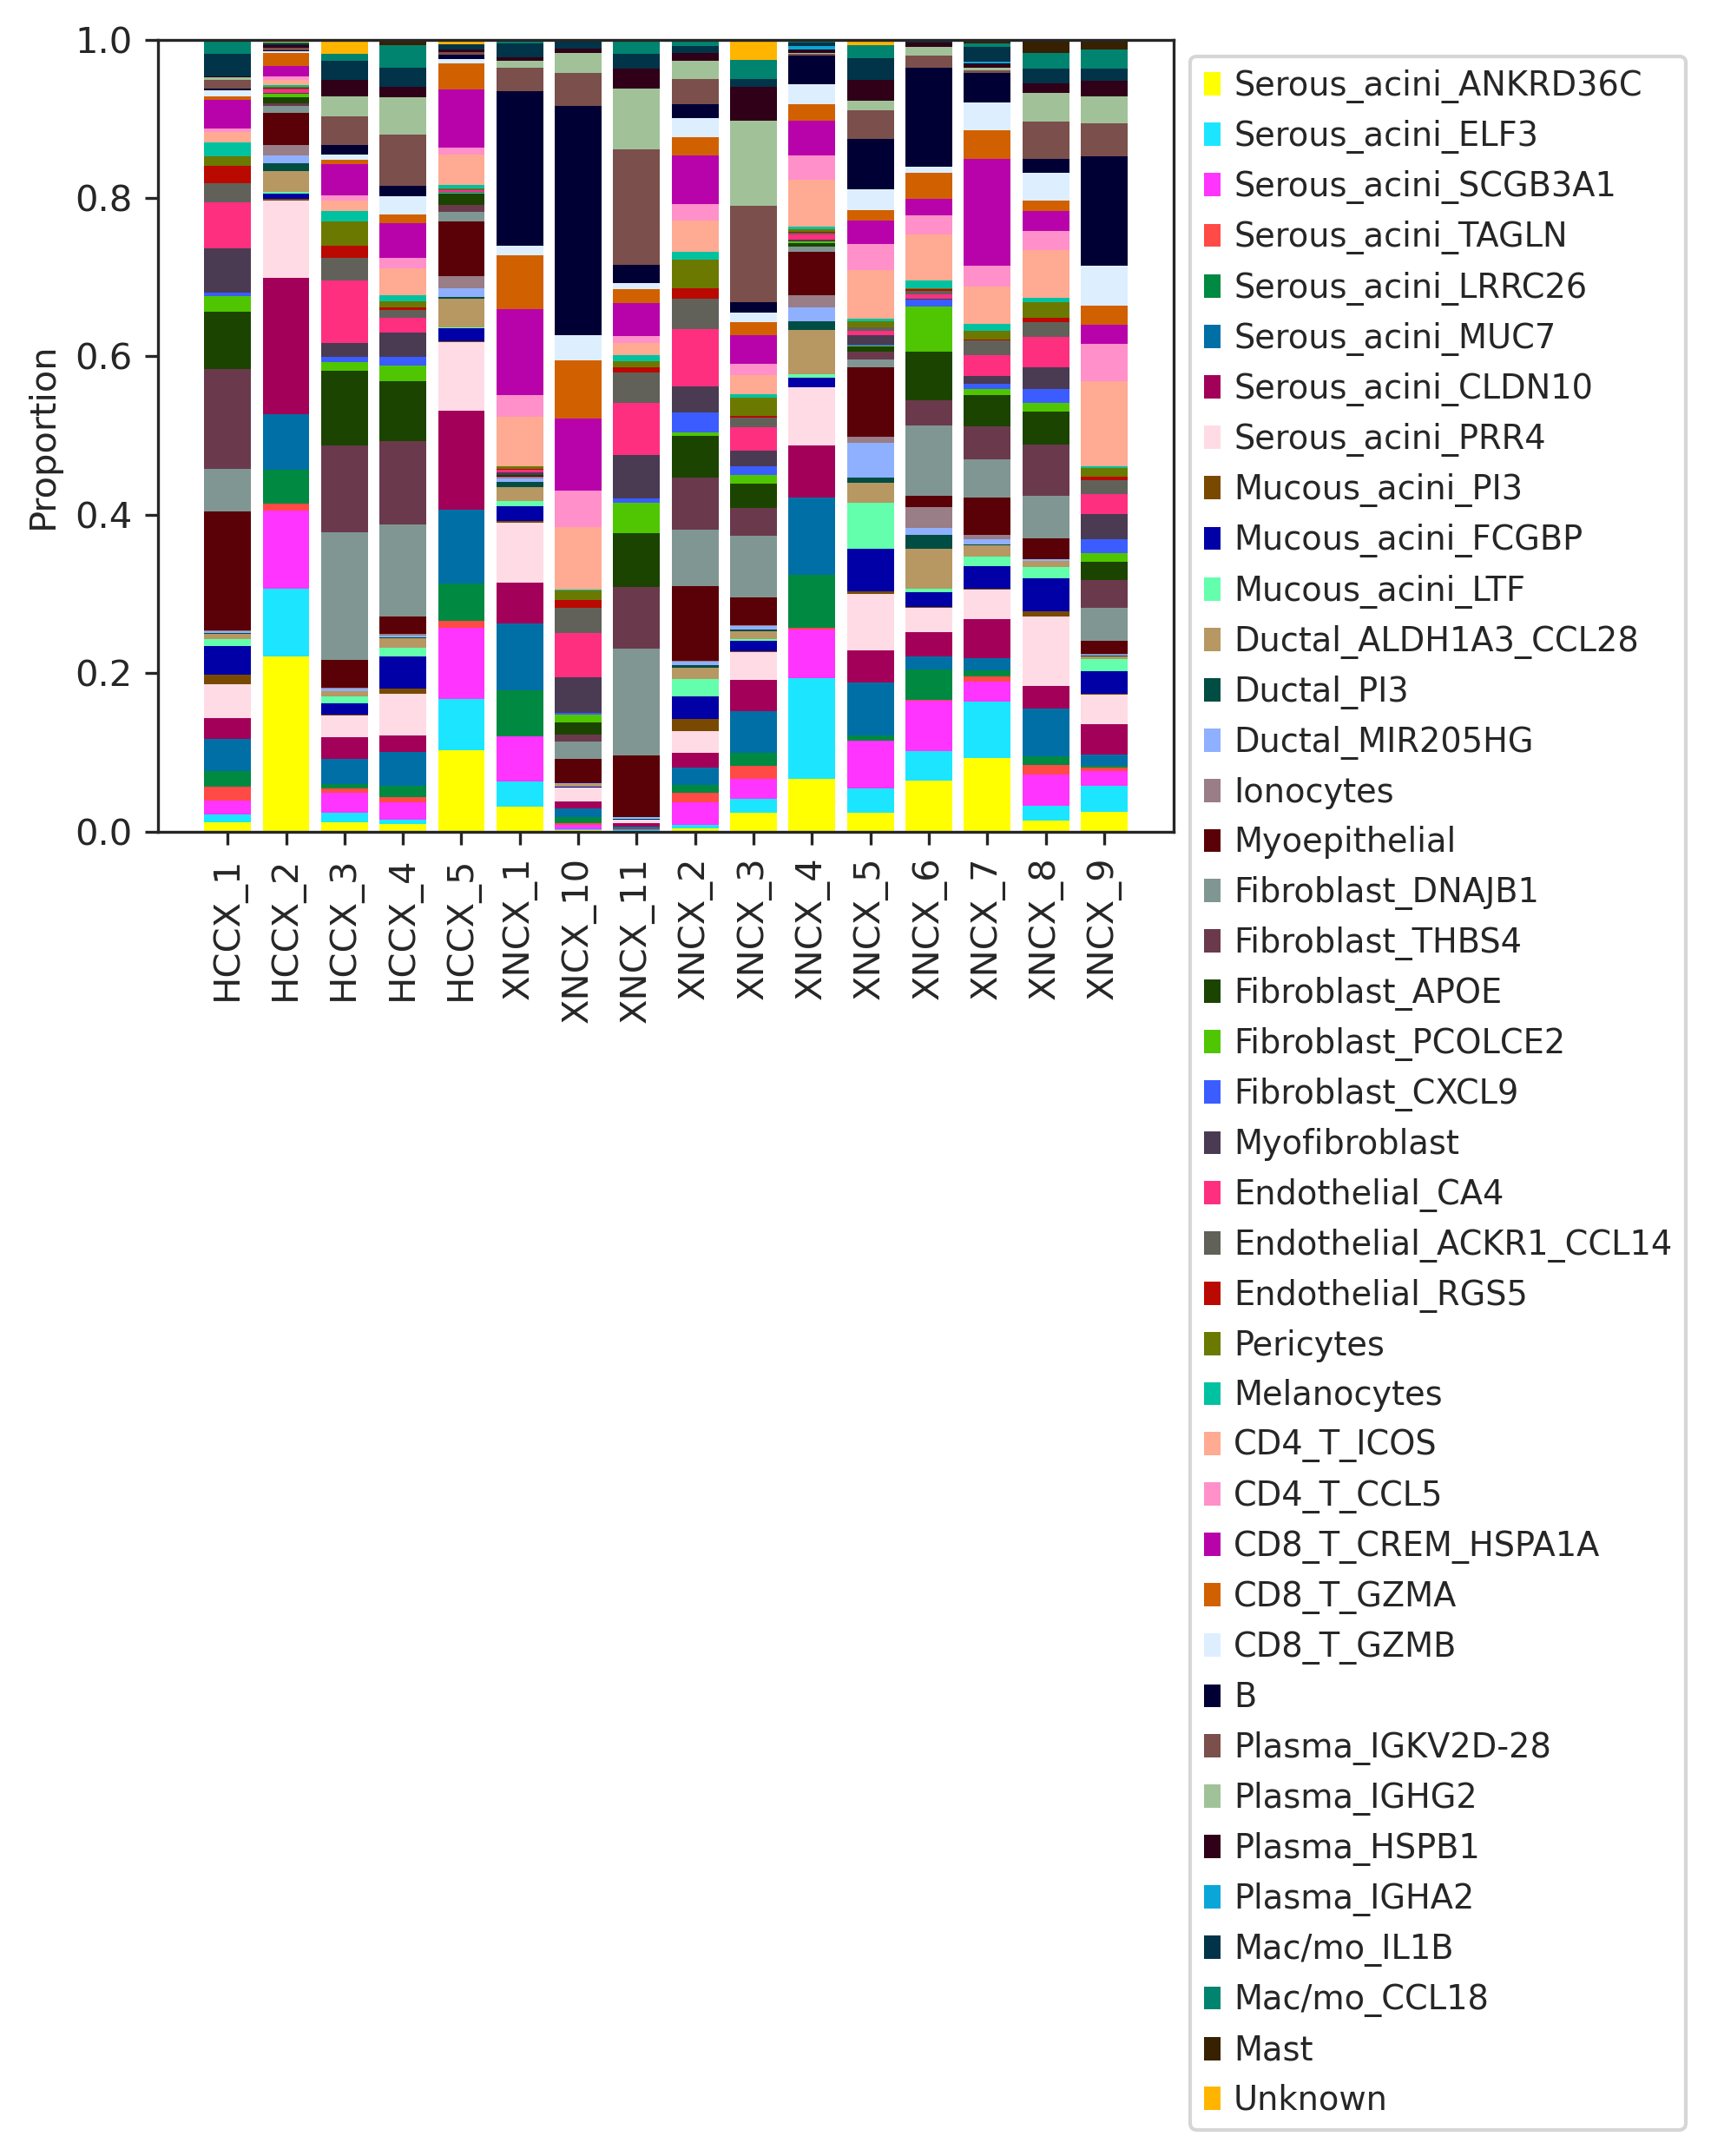

In [180]:
sns.set_style('ticks')
minor_p_df = sc_plot.plot_proportion(cx.obs,obs_x='sample',obs_y='celltype_minor',obs_y_order=cx.obs.celltype_minor.cat.categories,figsize=(5,4),colors=cx.uns['celltype_minor_colors'],save='figures/barplot_cx_sample_celltype_minor.pdf')

In [182]:
for i,c in enumerate(minor_p_df.index):
    print(c)
    print(ttest_ind(minor_p_df.iloc[i,:5],minor_p_df.iloc[i,5:]))

Serous_acini_ANKRD36C
Ttest_indResult(statistic=1.3155470327798473, pvalue=0.20946395742122217)
Serous_acini_ELF3
Ttest_indResult(statistic=0.08744341662716673, pvalue=0.9315574940475346)
Serous_acini_SCGB3A1
Ttest_indResult(statistic=1.0141470023555639, pvalue=0.32771972385680337)
Serous_acini_TAGLN
Ttest_indResult(statistic=1.297186654042127, pvalue=0.21553723308443046)
Serous_acini_LRRC26
Ttest_indResult(statistic=0.445404106838263, pvalue=0.6628375258278475)
Serous_acini_MUC7
Ttest_indResult(statistic=0.9068161385405921, pvalue=0.3798475375471473)
Serous_acini_CLDN10
Ttest_indResult(statistic=1.8509038720331483, pvalue=0.0853943528953456)
Serous_acini_PRR4
Ttest_indResult(statistic=1.0925589524449402, pvalue=0.2930321225997269)
Mucous_acini_PI3
Ttest_indResult(statistic=0.6925838237619707, pvalue=0.49989847713778013)
Mucous_acini_FCGBP
Ttest_indResult(statistic=0.05774735710816795, pvalue=0.9547660064642134)
Mucous_acini_LTF
Ttest_indResult(statistic=-0.8279146618386665, pvalue=0.4

In [193]:
minor_p_df_count = pd.DataFrame()

In [194]:
count = 0
for i in minor_p_df.index:
    for c in minor_p_df.columns:
        minor_p_df_count.loc[count,['celltype_minor','sample','proportion']] = [i,c,minor_p_df.loc[i,c]]
        count += 1

In [209]:
minor_p_df_count.loc[minor_p_df_count['sample'].isin(['HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5']),'cli_state'] = 'HC'
minor_p_df_count.loc[minor_p_df_count['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11']),'cli_state'] = 'SjS'

In [210]:
minor_p_df_count

,celltype_minor,sample,proportion,cli_state
0,Serous_acini_ANKRD36C,HCCX_1,0.011753,HC
1,Serous_acini_ANKRD36C,HCCX_2,0.220435,HC
2,Serous_acini_ANKRD36C,HCCX_3,0.011762,HC
3,Serous_acini_ANKRD36C,HCCX_4,0.008992,HC
4,Serous_acini_ANKRD36C,HCCX_5,0.102144,HC
...,...,...,...,...
651,Unknown,XNCX_5,0.006848,SjS
652,Unknown,XNCX_6,0.001247,SjS
653,Unknown,XNCX_7,0.000550,SjS
654,Unknown,XNCX_8,0.000430,SjS


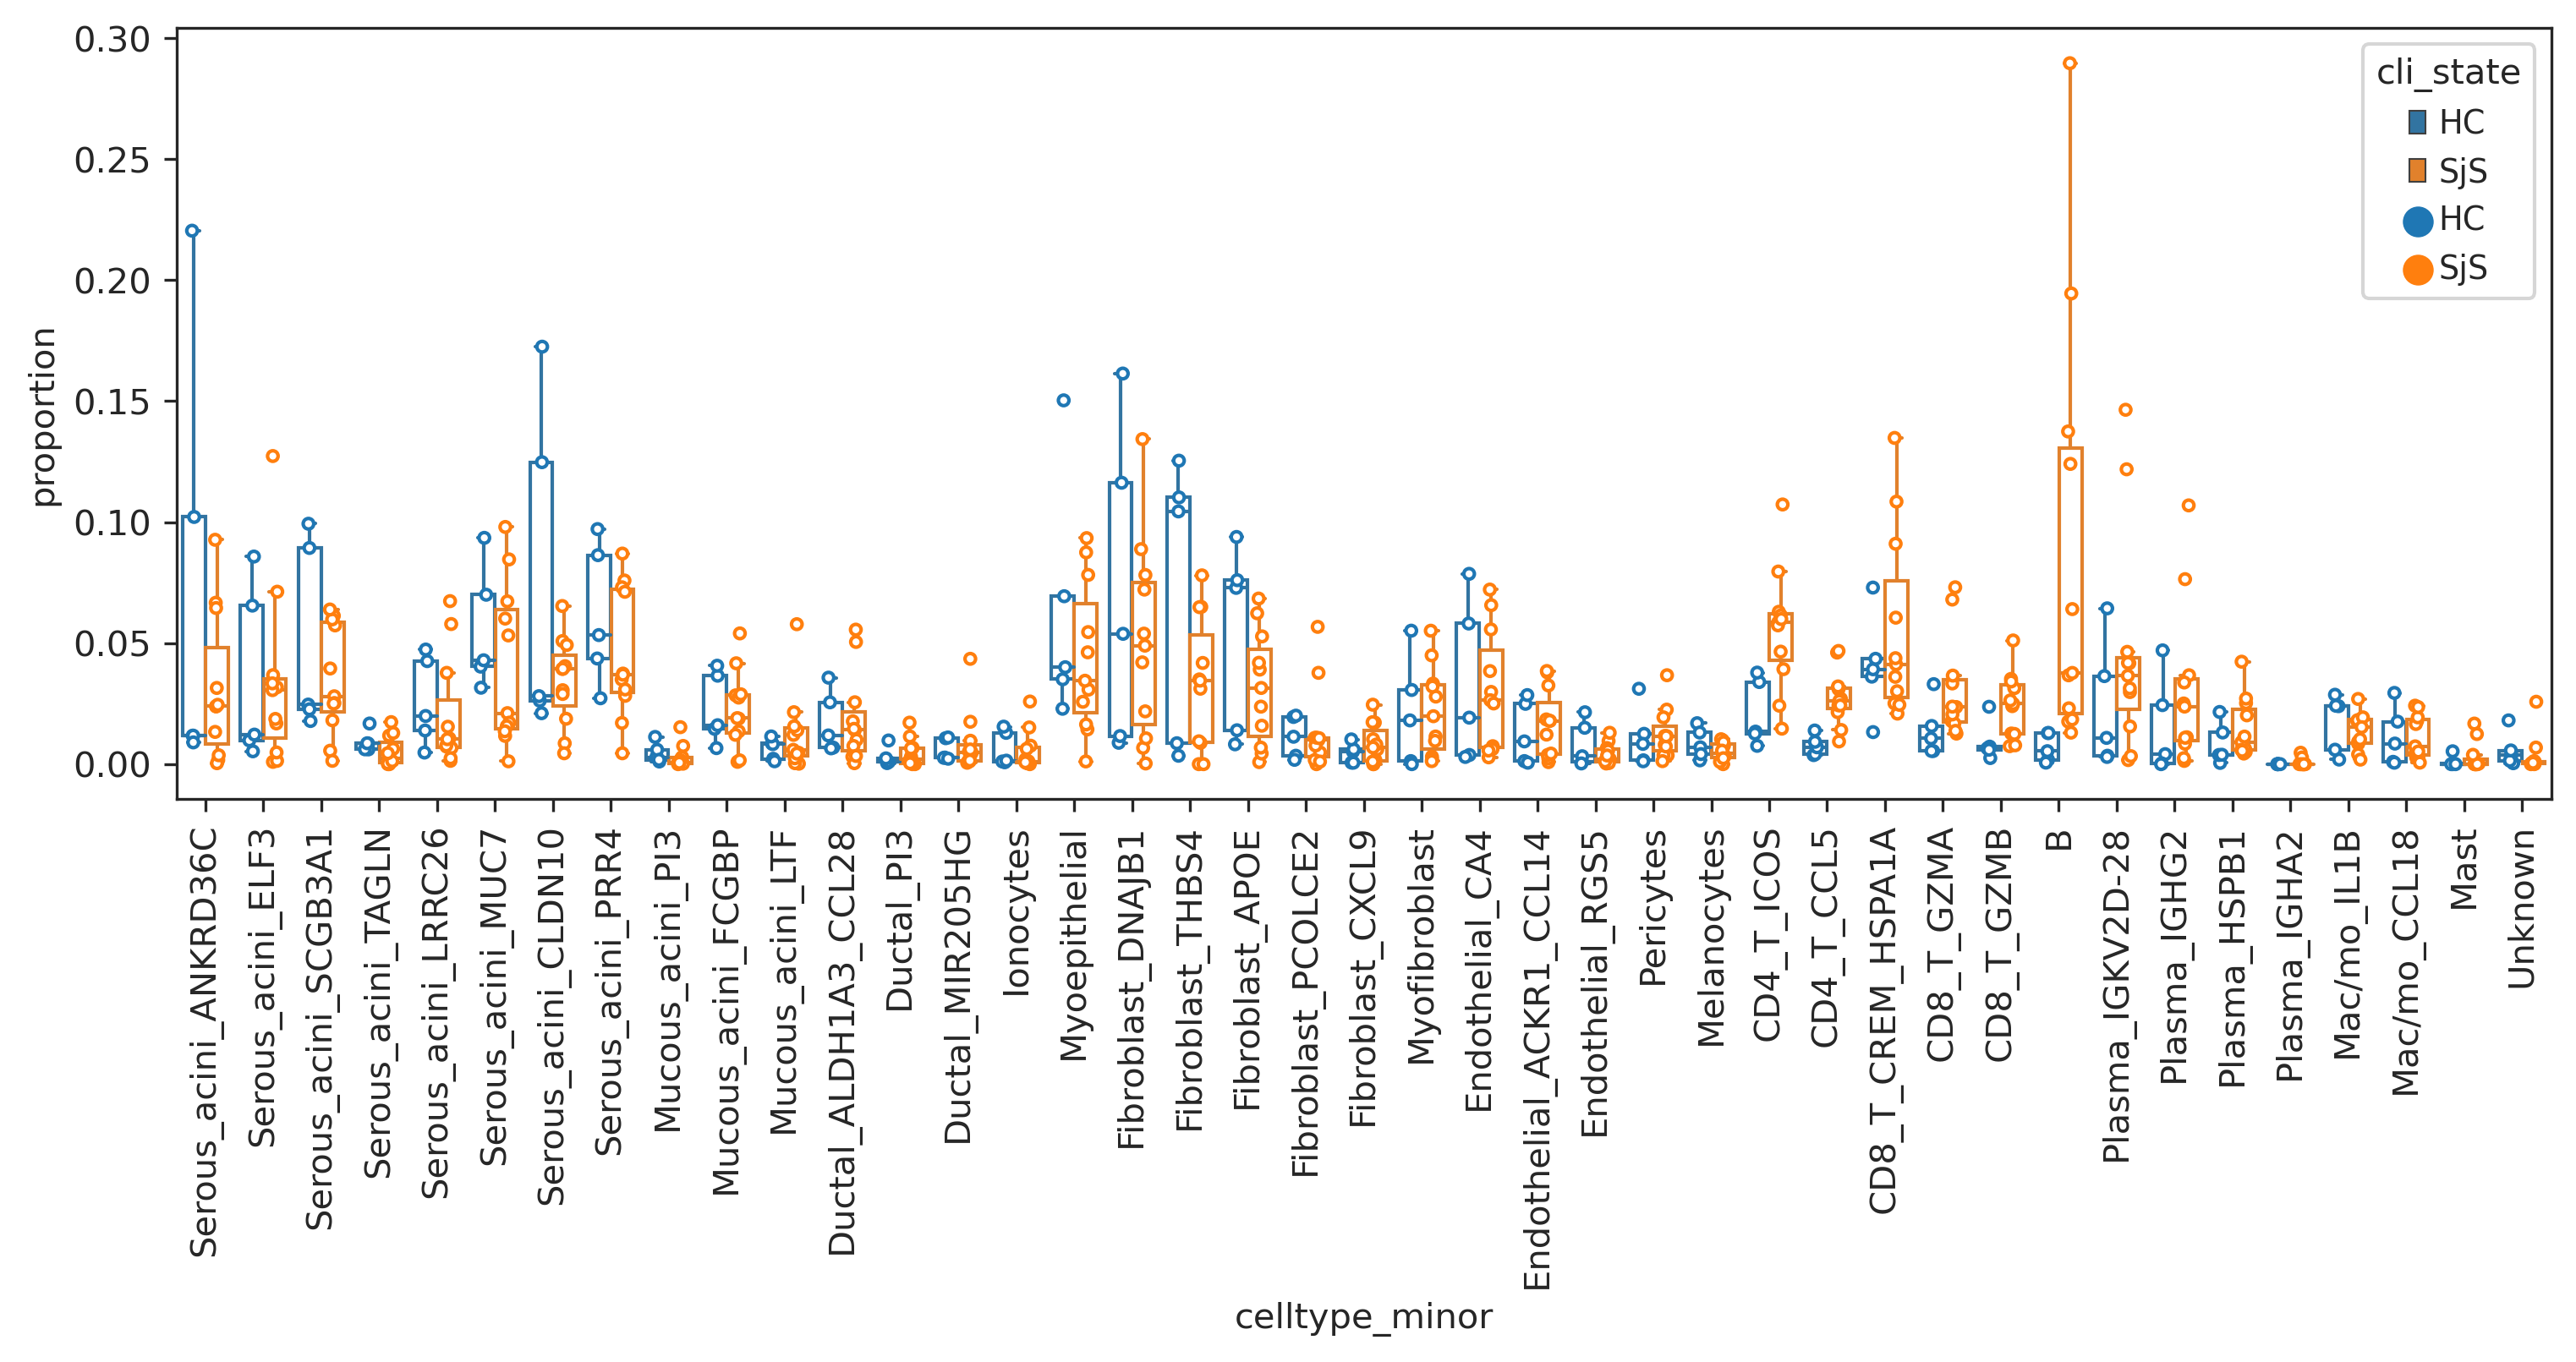

In [236]:
fig,ax=plt.subplots(figsize=(12,4))
sns.boxplot(data=minor_p_df_count,y='proportion',x='celltype_minor',hue='cli_state',ax=ax,fliersize=0,linewidth=1)
sns.stripplot(data=minor_p_df_count,y='proportion',x='celltype_minor',hue='cli_state',ax=ax,dodge=True,size=3,linewidth=1)
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.savefig('figures/boxplot_cx_celltype_minor_proportion.pdf',bbox_inches='tight')
plt.show()